# March Madness Bracket Predictor

### The objective of this project is to use machine learning models in order to predict the outcomes of March Madness games, then using these predictions to generate a bracket. 

*This project is a work in progress. The initial goal is to get a minimum working example and then progressively improve the results via data exploration, additional models, further hyperparameter tuning, etc.*

## Outline:
1. Problem Definition
2. Data Explaination
3. Evaluation
4. Feature Selection
5. Modeling
6. Results and Summary

## 1. Problem Definition
March Madness is the post season, 64-team bracket for (Men's) NCAA Basketball. The winner of the tournament is deemed the national champion. It is common practice to individually fill out these brackets prior to the start of the first game. The objective of this project is to predict the outcome of a game between two selected teams, this infomation will then be used to generate an entire bracket of predictions.

In [6]:
#Basic imports, they were added as needed

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

## 2. Data Explanation
This project is currently using data from [RealGM](https://basketball.realgm.com/ncaa/team-stats/2022/Totals/Team_Totals/0). The data contains numerous statistics of each team from the year 02-03 until 21-22 (excluding 19-20 and 20-21 due to COVID irregularities). These statistics include:
* seed = Seed in the NCAA tournament
* wins = Number of wins
* losses = Number of losses
* winp = Win percentage
* cwins = Number of conference wins
* closses = Number of conference losses
* cwinp = Conference win percentage
* pts = Number of points scored
* ptspg = Points per game
* fgm = Number of field goals made
* fga = Number of field goals attempted
* fgp = Field goal percentage
* 3pm = Number of 3 pointers made
* 3pa = Number of 3 pointers attempted
* 3pp = 3 pointer percentage 
* ftm = Number of free throws made
* fta = Number of free throws attempted
* ftp = Free throw percentage
* orb = Number of offensive rebounds
* orbpg = Offensive rebounds per game
* drb = Number of defensive rebounds
* drbpg = Defensive rebounds per game
* reb = Number of rebounds
* rebpg = Rebounds per game
* ast = Number of assists
* astpg = Assists per game
* stl = Number of steals
* stlpg = Steals per game
* blk = Number of blocks
* blkpg = Blocks per game
* tov = Number of turnovers
* tovpg = Turnovers per game
* pf = Number of personal fouls
* pfpg = Personal fouls per game

We will utilize the above attributes to represent each team. For each game, we represent the winner by their stat vector $W = \langle \text{seed, wins, losses,} \dots \text{, pf, pfpg}\rangle$. We represent the loser, $L$ in a similar fashion. Each game is then morphed into two feature vectors: $\langle W - L, 1 \rangle$ and $\langle L - W, 0 \rangle$ to properly account for substraction not being a commutative operation.

In [7]:
# load the feature vector dataframe
df = pd.read_csv("feature-vectors.csv")
df

,year,seed,wins,losses,winp,cwins,closses,cwinp,pts,ptspg,...,astpg,stl,stlpg,blk,blkpg,tov,tovpg,pf,pfpg,result
0,2003,-15,8,-9,0.269,6,-4,0.286,122.0,6.046,...,2.886,-34.0,-0.795,106.0,3.370,-71.0,-1.728,-84.0,-2.018,1
1,2003,15,-8,9,-0.269,-6,4,-0.286,-122.0,-6.046,...,-2.886,34.0,0.795,-106.0,-3.370,71.0,1.728,84.0,2.018,0
2,2003,1,1,-2,0.055,1,-5,0.230,-554.0,-15.219,...,-4.211,-108.0,-3.225,29.0,1.025,-100.0,-2.738,-53.0,-1.034,1
3,2003,-1,-1,2,-0.055,-1,5,-0.230,554.0,15.219,...,4.211,108.0,3.225,-29.0,-1.025,100.0,2.738,53.0,1.034,0
4,2003,-7,-4,2,-0.080,-2,4,-0.250,-260.0,-3.824,...,-0.918,-4.0,0.323,58.0,2.054,-88.0,-2.165,-151.0,-3.914,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2263,2022,-6,4,-3,0.097,1,-1,0.050,168.0,2.661,...,2.094,42.0,1.077,62.0,1.711,-36.0,-1.401,-10.0,-0.717,0
2264,2022,-1,2,-1,0.036,-2,0,-0.022,275.0,5.952,...,3.380,12.0,0.170,67.0,1.905,96.0,2.529,36.0,0.611,1
2265,2022,1,-2,1,-0.036,2,0,0.022,-275.0,-5.952,...,-3.380,-12.0,-0.170,-67.0,-1.905,-96.0,-2.529,-36.0,-0.611,0
2266,2022,-7,4,-3,0.097,-1,-1,0.028,114.0,1.073,...,0.623,40.0,1.018,15.0,0.329,42.0,0.893,65.0,1.489,1


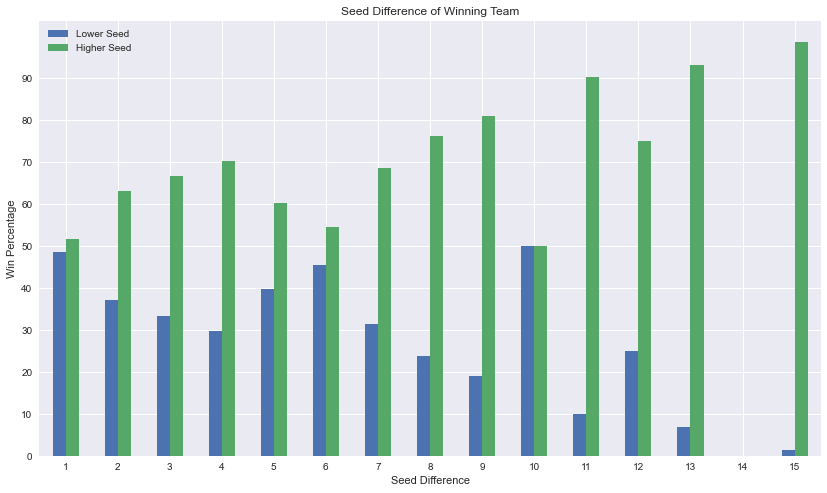

In [8]:
seeds = pd.DataFrame()
seed_df = df[df["result"] == 0]["seed"]
counts = seed_df.value_counts()
for i in range(1, 16):
    total_seeds = counts.get(i, 0) + counts.get(-1*i, 0)
    if total_seeds != 0:
        seeds[i] = [counts.get(-1*i, 0)/total_seeds, counts.get(i, 0)/total_seeds]
    else:
        seeds[i] = [0, 0]
seeds = (seeds.round(3))*100

seeds.T.plot.bar(figsize=(14,8))
plt.title("Seed Difference of Winning Team")
plt.legend(["Lower Seed", "Higher Seed"])
plt.xlabel("Seed Difference")
plt.xticks(rotation = 0)
plt.ylabel("Win Percentage")
plt.yticks(np.arange(0, 100, 10));

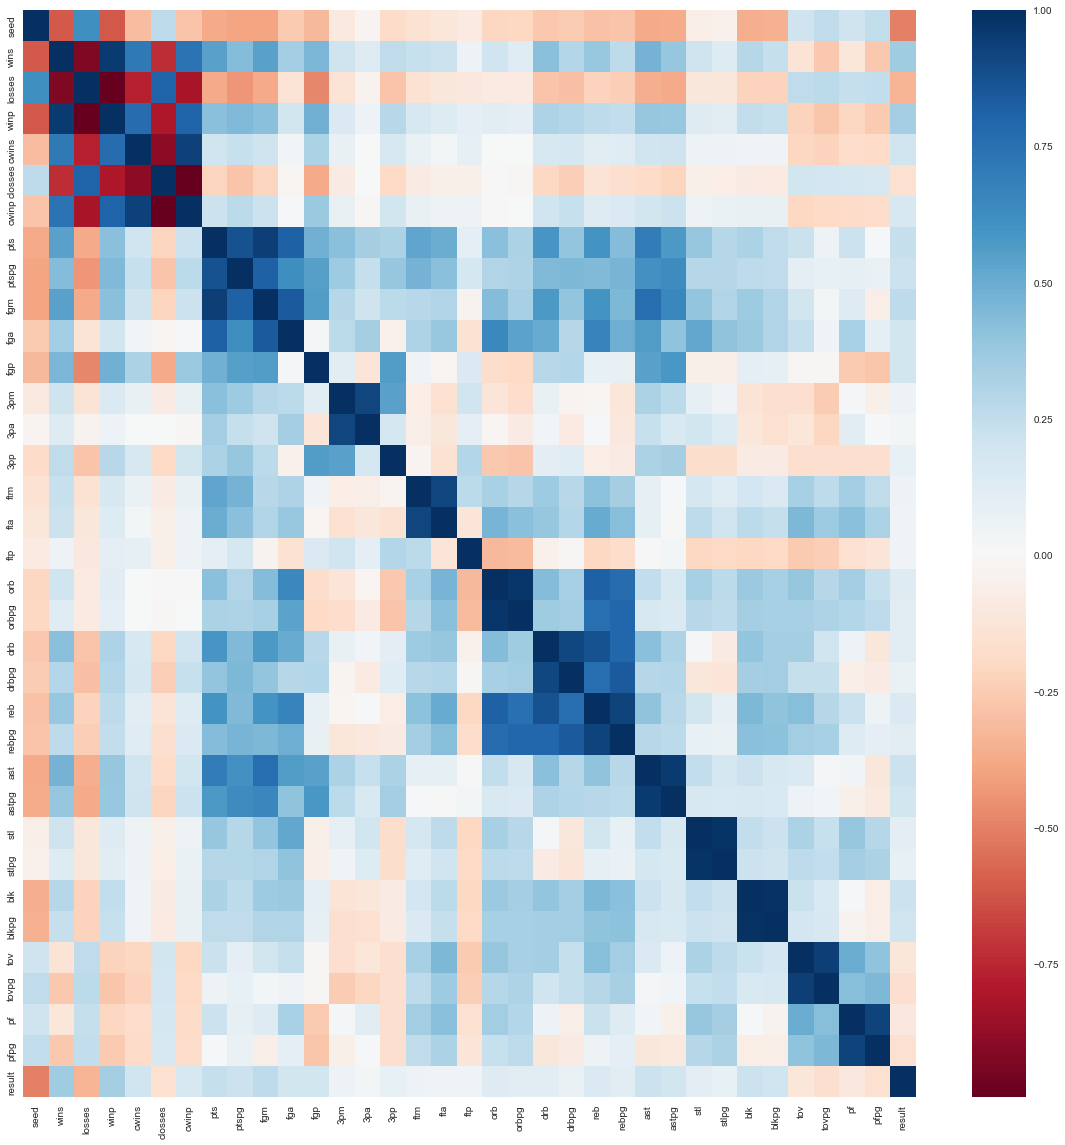

In [9]:
plt.figure(figsize=(20,20))
corrMatrix = df.drop("year", axis=1).corr()
sns.heatmap(corrMatrix, annot=False, cmap="RdBu");

In [10]:
corrMatrix.iloc[-1]

seed      -0.497842
wins       0.355856
losses    -0.334995
winp       0.343467
cwins      0.203565
closses   -0.157216
cwinp      0.171589
pts        0.240031
ptspg      0.215872
fgm        0.263194
fga        0.191475
fgp        0.192206
3pm        0.063630
3pa        0.033786
3pp        0.086501
ftm        0.059113
fta        0.043701
ftp        0.043973
orb        0.135150
orbpg      0.113401
drb        0.117962
drbpg      0.072702
reb        0.148272
rebpg      0.111859
ast        0.213823
astpg      0.191419
stl        0.105120
stlpg      0.082921
blk        0.215651
blkpg      0.203633
tov       -0.117140
tovpg     -0.163825
pf        -0.104632
pfpg      -0.154207
result     1.000000
Name: result, dtype: float64

In [11]:
corrMatrix.iloc[1]

seed      -0.606173
wins       1.000000
losses    -0.931376
winp       0.959909
cwins      0.717892
closses   -0.734405
cwinp      0.741858
pts        0.548007
ptspg      0.433764
fgm        0.541646
fga        0.349411
fgp        0.461688
3pm        0.210544
3pa        0.130795
3pp        0.256251
ftm        0.235091
fta        0.213889
ftp        0.062779
orb        0.203044
orbpg      0.126208
drb        0.422293
drbpg      0.292656
reb        0.379458
rebpg      0.261146
ast        0.471815
astpg      0.386948
stl        0.209781
stlpg      0.137267
blk        0.288411
blkpg      0.243750
tov       -0.130193
tovpg     -0.262780
pf        -0.116367
pfpg      -0.264024
result     0.355856
Name: wins, dtype: float64